In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [25]:
song_data = pd.read_csv('data/playlists-v4-final.csv')

# Create the sorted dataframe, drop zeros, convert any categoricals
sort_data = song_data.sort_values('popularity_scores', ascending=False).reset_index()
ordered = sort_data.drop(['index', 'genre', 'id'], axis=1)
ordered.index = ordered.index + 1
ordered = ordered[ordered.popularity_scores > 0]

ordered[['mode', 'key', 'time_signature']] = \
    ordered[['mode', 'key', 'time_signature']].astype('category')

In [26]:
ordered.shape

(7332, 15)

After dropping all of the observations with a popularity of zero, roughly 7332 rows remain. Furthermore, there are 14 features and one target variable. Looking at the first few rows shows the types of features and gives a sense of how the data is sorted.

In [27]:
ordered.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,song_title,popularity_scores
1,0.637,0.643,4,-6.571,1,0.0519,0.13000,0.000002,0.1420,0.533,97.008,200690,4,Anti-Hero,97
2,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,175238,4,I'm Good (Blue),97
3,0.520,0.731,6,-5.338,0,0.0557,0.34200,0.001010,0.3110,0.662,173.930,167303,4,As It Was,93
4,0.565,0.636,0,-8.198,1,0.0638,0.10700,0.000010,0.4470,0.525,170.010,179551,4,SNAP,92
5,0.464,0.417,0,-9.345,0,0.0256,0.13600,0.022000,0.0974,0.479,67.528,183956,4,I Wanna Be Yours,92


<b>Adding a new column</b><br>
The linear regression models didn't work, so I split the observations into three classes based on the popularity scores: `unpopular` for scores up to 50, `medium` for 51 to 74, and `popular` for 75 and above to follow the classification approach.

In [28]:
classified = ordered.copy()
classified['popular_rating'] = ''

for i, row in classified.iterrows():
    score = 'unpopular'
    if (row.popularity_scores > 50) & (row.popularity_scores < 75):
        score = 'medium'
    elif row.popularity_scores >= 75:
        score = 'popular'
    classified.at[i, 'popular_rating'] = score

In [29]:
# Inspect the new column
classified[['song_title', 'popularity_scores', 'popular_rating']].head(3)

,song_title,popularity_scores,popular_rating
1,Anti-Hero,97,popular
2,I'm Good (Blue),97,popular
3,As It Was,93,popular


### Visual EDA

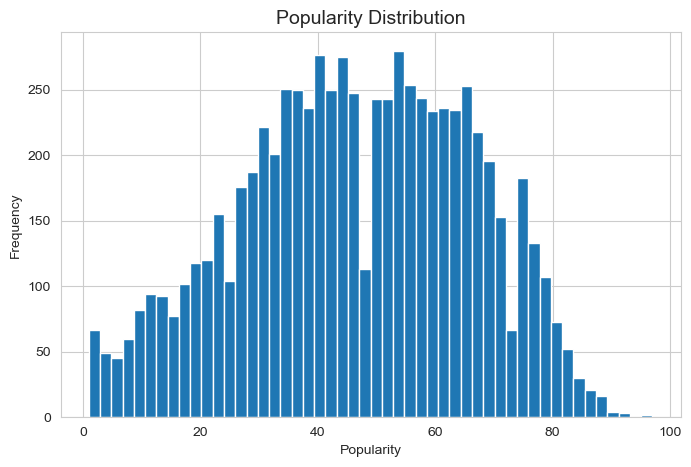

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = ordered['popularity_scores'].plot(kind='hist', bins=50)
_ = plt.xlabel('Popularity')
_ = plt.title('Popularity Distribution', fontsize=14)

To study this dynamic further, we can look at the statistical moments for the popularity column.

In [31]:
ordered[['popularity_scores']].describe()

,popularity_scores
count,7332.000000
mean,46.391844
std,19.565883
min,1.000000
25%,32.000000
50%,47.000000
75%,62.000000
max,97.000000


From the above we can see the low measures of centrality. The mean and median are both in the 40s and the IQR only extends to 62. Even songs of a medium popularity as defined in the classified dataset would be fairly rare. This makes sense given that popular radio is often branded as "Top 40" and there are thousands of songs in  the data, but the large imbalance will need to be accounted for later on.

<b>Correlations</b><br>

In [32]:
ordered.corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_scores
danceability,1.000000,0.355967,0.432359,0.253943,-0.370806,-0.450345,-0.027564,0.552342,-0.027316,-0.149608,0.289961
energy,0.355967,1.000000,0.801961,0.218504,-0.738664,-0.411300,0.194901,0.484420,0.207112,-0.026663,0.256343
loudness,0.432359,0.801961,1.000000,0.167866,-0.633010,-0.610792,0.136522,0.437774,0.193684,-0.096984,0.322229
speechiness,0.253943,0.218504,0.167866,1.000000,-0.208992,-0.158903,0.081885,0.134352,0.090175,-0.062927,0.072069
acousticness,-0.370806,-0.738664,-0.633010,-0.208992,1.000000,0.366573,-0.111749,-0.282367,-0.169555,0.077107,-0.313625
instrumentalness,-0.450345,-0.411300,-0.610792,-0.158903,0.366573,1.000000,-0.105587,-0.425739,-0.132303,0.047389,-0.347425
liveness,-0.027564,0.194901,0.136522,0.081885,-0.111749,-0.105587,1.000000,0.081201,0.028503,0.046222,0.006260
valence,0.552342,0.484420,0.437774,0.134352,-0.282367,-0.425739,0.081201,1.000000,0.114463,-0.093719,0.184823
tempo,-0.027316,0.207112,0.193684,0.090175,-0.169555,-0.132303,0.028503,0.114463,1.000000,-0.032889,0.084282
duration_ms,-0.149608,-0.026663,-0.096984,-0.062927,0.077107,0.047389,0.046222,-0.093719,-0.032889,1.000000,-0.129784


To also visualize these correlations, a heatmap is useful.

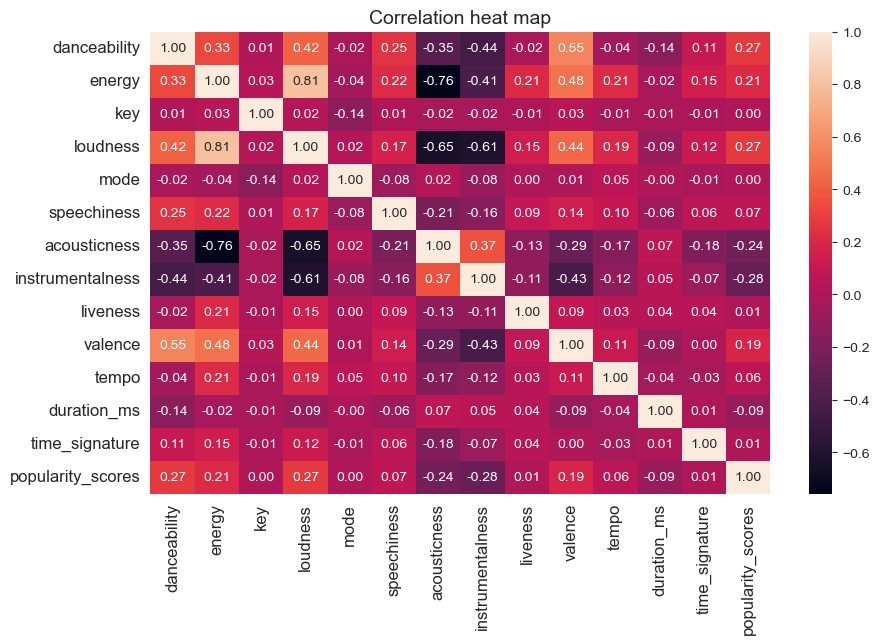

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
_ = sns.heatmap(song_data.corr(), annot=True, fmt=".2f",)
_ = plt.title('Correlation heat map', fontsize=14)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

From the above chart and heatmap, the correlations are mostly pretty weak. Energy, loudness, danceability, and valence have fairly strong relationships, which makes sense, and acousticness is naturally opposed to loudness and energy, but there's not much to go on outside of those. Unfortunately, this trend appears to hold true for the popularity variable. The correlation between loudness, danceability and popularity looks positive, but it would be nice to have a dependent variable that strongly relates to the target variable.

<b>Further examining specific variables</b><br>
Having established a general overview of the dependent and independent variables, the next step is to dive deeper into these relationships. The next several plots explore the relationship between certain features and the target variable. First, two functions are defined in order to create multiple plots.

In [34]:
def scat_plot(x, y, hue=None, xlab='', ylab='', titl=''):
    '''Plots a scatterplot using given inputs'''
    fig, ax = plt.subplots(figsize=(10,6))
    _ = sns.scatterplot(x, y, hue=hue, s=12)
    _ = plt.xlabel(xlab, fontsize=12)
    _ = plt.ylabel(ylab, fontsize=12)
    _ = plt.title(titl, fontsize=14)
    _ = plt.legend(fontsize=12)
    plt.show()
    
    
def regress_plot(x='', y='', data=None, xlab='', ylab='', titl=''):
    '''Plots a scatterplot with a regression line
    using given inputs'''
    fig, ax = plt.subplots(figsize=(10,6))
    _ = sns.regplot(x, y, data=data, scatter_kws={"s": 10}, line_kws={'color':'r'})
    _ = plt.xlabel(xlab, fontsize=12)
    _ = plt.ylabel(ylab, fontsize=12)
    _ = plt.title(titl, fontsize=14)
    _ = plt.ylim(-3, 103)
    plt.show()

From the correlation heatmap, the best predictor seemed to be loudness. The newly defined `scat_plot` function can be used to examine it further.

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


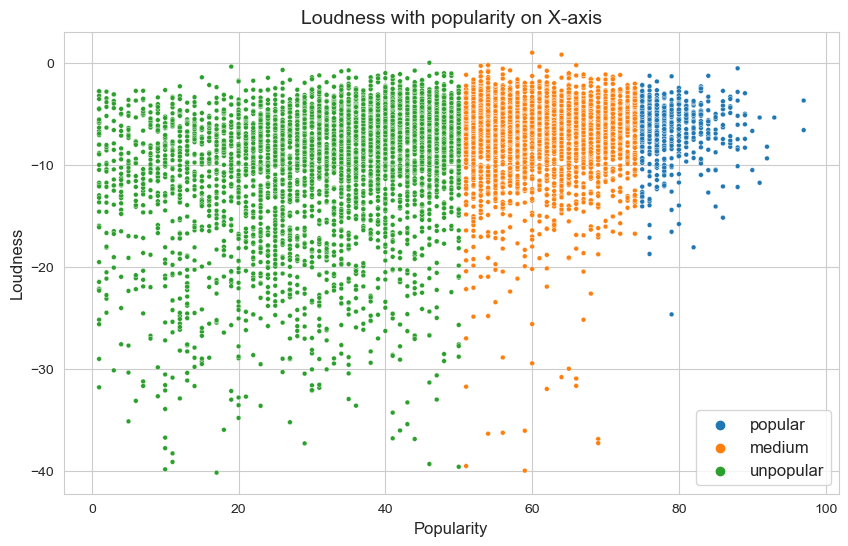

In [35]:
s = ordered

scat_plot(s.popularity_scores, s.loudness, hue=classified.popular_rating, xlab='Popularity',\
         ylab='Loudness', titl='Loudness with popularity on X-axis')

The plot above shows the distribution of loudness with popularity on the X-axis. It shows that the highest values of loudness can be found acoss the popularity spectrum, but as the X-axis increases the groupings become more and more concentrated toward the top. In other words, loudness doesn't guarantee popularity, but low levels of loudness seem to preclude popularity.<br>
<br>
Now with the `regress_plot` function:

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


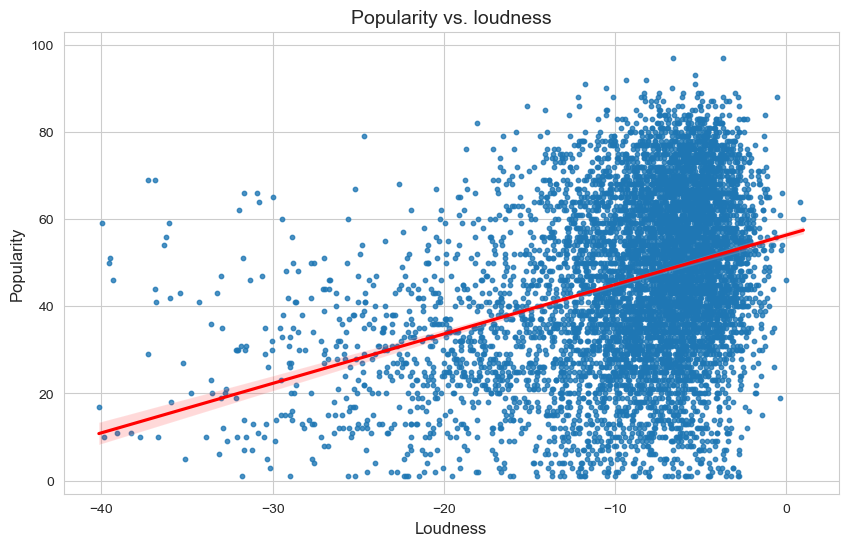

In [36]:
regress_plot('loudness', 'popularity_scores', data=s, xlab='Loudness',\
         ylab='Popularity', titl='Popularity vs. loudness')

The regressor clearly shows there is a positive correlation, and the data tends to narrow towards the top, but overall the observations are quite scattered. It's not a very strong fit.<br>
<br>
While loudness has the strongest correlation, for comparison sake, let's look at the other end of the spectrum with instrumentalness. Again, we can do so with both the `scat_plot` and `regress_plot`.

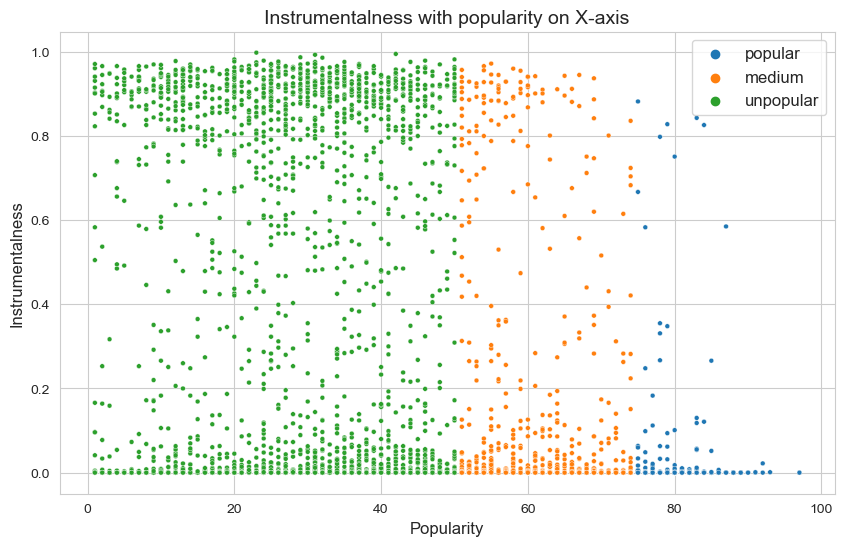

In [37]:
scat_plot(s.popularity_scores, s.instrumentalness, hue=classified.popular_rating, xlab='Popularity',\
         ylab='Instrumentalness', titl='Instrumentalness with popularity on X-axis')

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


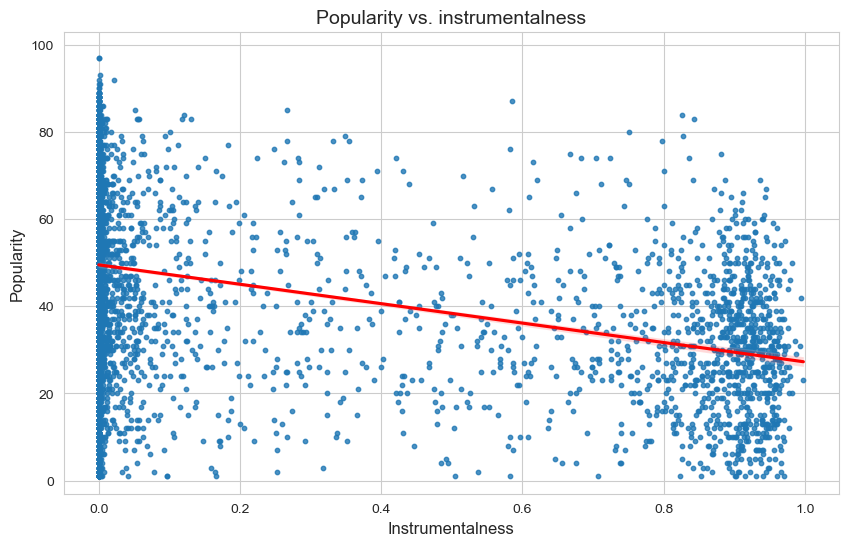

In [38]:
regress_plot('instrumentalness', 'popularity_scores', data=s, xlab='Instrumentalness',\
         ylab='Popularity', titl='Popularity vs. instrumentalness')

Continuing to look at a couple other variables, we can quickly examine energy and danceability using subplots.

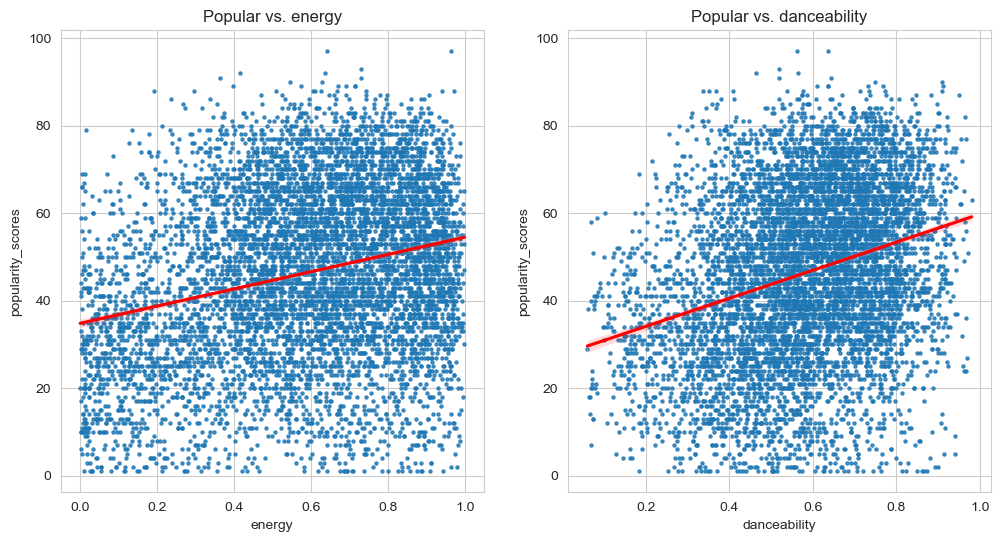

In [39]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(1,2,1)
_ = sns.regplot(s.energy, s.popularity_scores, scatter_kws={"s": 5}, line_kws={'color':'r'})
_ = plt.title('Popular vs. energy')

ax2 = plt.subplot(1,2,2)
_ = sns.regplot(s.danceability, s.popularity_scores, scatter_kws={"s": 5}, line_kws={'color':'r'})
_ = plt.title('Popular vs. danceability')

The story for these variables is similar to the previous ones. 

In general, There is a lot of noise and variability amongst the observations. But honestly, thinking intuitively about song popularity, this shouldn't be too surprising. Unpopular songs and popular songs can have many similarities, and all popular songs can have many differences. The purpose of this project is to see if an algorithm can sort out these differences and similarities better than a human could. That is what the next section looks into.